#Classification de Spam et Ham avec XLM-Roberta


## Introduction

L'objectif principal de ce projet est d'utiliser le modèle pré-entraîné XLM-Roberta dans une tâche de classification de texte pour identifier des mails indésirables. Nous allons construire une pipeline complète, de la préparation des données à l'évaluation du modèle.

La classification de spam est une application importante de l'apprentissage automatique dans le domaine du traitement du langage naturel (NLP). Dans ce projet, nous utiliserons le modèle XLM-Roberta, qui est un modèle de langage multilingue robuste, pour distinguer les e-mails indésirables des e-mails légitimes. A noter que les mails utilisés pour cet apprentissage seront en anglais.

# Importing libraries

In [1]:
debug = False

In [2]:
!pip install transformers
!pip install sentencepiece
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import chardet
import seaborn as sns
import plotly.graph_objects as go
import time
import shutil

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import sentencepiece

import warnings
warnings.simplefilter('ignore')
scaler = torch.cuda.amp.GradScaler()

# About the Dataset

Le dataset que nous allons utilisé provient de kaggle et plus précisement du dossier enron1 (https://www2.aueb.gr/users/ion/data/enron-spam/). Ce dataset contient plusieurs exemple de mails indésirables et légitimes en anglais. On retrouve donc en attribut le label (en numérique et en texte) et le contenu du mail.

## Loading the Dataset

In [3]:
file="/content/spam_ham_dataset.csv"
data=pd.read_csv(file)
data.columns=['#','label','text','targets']
data=data.drop('#', axis=1)
display(data)


,label,text,targets
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,ham,Subject: industrial worksheets for august 2000...,0


Pour les besoins de l'étude et de l'efficacité des pré-traitements nous avons créé une petite fonction qui fixe la seed de génération. Cette fonction nous assure la reproductibilité des résultats par la reproductibilité de tous les tirages des nombres aléatoires, les opérations de mélange et les calculs basés sur l'horloge.

In [4]:
# Set the random seed for Torch, Cuda and numpy
def random_seed(SEED):

    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


#SEED = 508
SEED = int(random.random()*100)
random_seed(SEED)

Nous commençons classiquement par séparer le dataset en trois set : training, validation et test. Le training set permettra l'apprentissage du modèle sur les dataset et le validation set permettra de vérifier si l'on trouve dans une situation de sur ou de sous-apprentissage. Le test set permettra de mesurer les performances finales du modèles après son apprentissage.

In [5]:
max_sens = 8
train, test = train_test_split(data, test_size=0.2, random_state=SEED)
train, valid = train_test_split(train, test_size=0.2, random_state=SEED)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
valid = valid.reset_index(drop=True)

print('train set')
display(train.info())
print('\nvalidation set')
display(valid.info())
print('\ntest set')
display(test.info())

train set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3308 entries, 0 to 3307
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    3308 non-null   object
 1   text     3308 non-null   object
 2   targets  3308 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 77.7+ KB


None


validation set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828 entries, 0 to 827
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    828 non-null    object
 1   text     828 non-null    object
 2   targets  828 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 19.5+ KB


None


test set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    1035 non-null   object
 1   text     1035 non-null   object
 2   targets  1035 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 24.4+ KB


None

## Visualizing the Data

Dans cette partie nous allons visualiser le dataset pour étudier et vérifier certaines priorités qui pourraient impacter l'apprentissage. Nous commençons par nous assurer que le dataset ne possède pas de valeurs nulles. Nous avons aussi utilisé ce bloc pour s'assurer que le tokenizer utilisé plus tard ne génère pas de valeures nulles qui feraient sauté la pipeline.

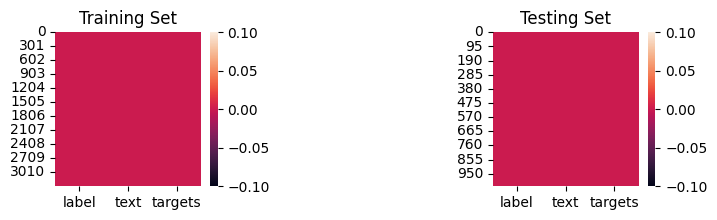

In [6]:
plt.figure(figsize = (8, 2))

plt.subplot(1, 3, 1)
plt.title("Training Set")
sns.heatmap(train.isnull())

plt.subplot(1, 3, 3)
plt.title("Testing Set")
sns.heatmap(test.isnull())
plt.show()

Maintenant nous allons pouvoir vérifier quelle répartition de spam et de ham il y a dans chaque notre dataset:




In [7]:
label_count = train['label'].value_counts().sort_index()
label_count

class_names = ['ham', 'spam'] #SET 0/1 →ham/spam
label_count.index = class_names
display(label_count)

fig = go.Figure([go.Bar(x=class_names, y=label_count, marker_color='skyblue')])

fig.update_layout(title_text='Number of entries per label in the training set', # title of plot
                  xaxis_title_text='Label', # xaxis label
                  yaxis_title_text='Count', # yaxis label
                  )
fig.show()

ham     2354
spam     954
Name: label, dtype: int64

On retrouve une proportion de 1 spam pour 2.5 ham ce qui n'est pas le cas idéale de l'égalité des proportions. Il est fort probable que les perforamnces de prédiction des spams soient moins bonnes.

Il est également intéressant de vérifier que cette répartition de proportion entre ham et de spam  ne soit pas dépedante de la taille des mails. On pourrait penser que les mails de spam suivent une certaine architecture et sont tous d'une certaine longuer, ce qui pourrait fausser l'apprentissage. Ci-dessous nous pouvons voir la proportion de ham/spam en fonction de la longueur du mail dans le training et le testing set restent à peu près constante :

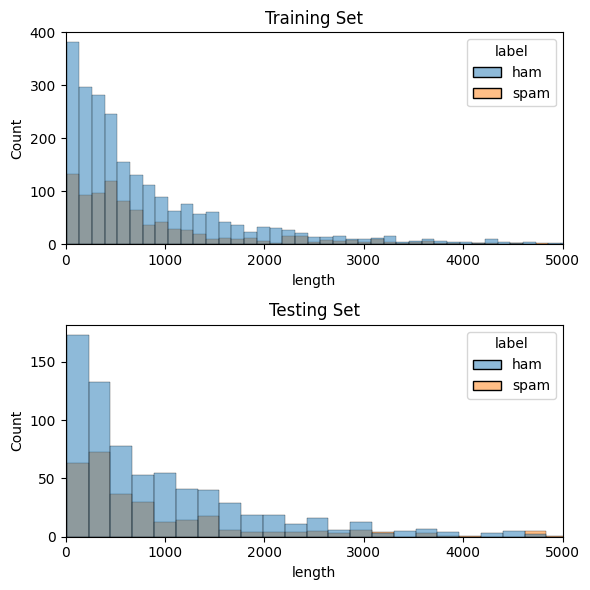

In [8]:
plt.figure(figsize=(6, 6))

plt.subplot(2, 1, 1)
plt.title("Training Set")
train['length'] = train['text'].apply(len)
sns.histplot(train, x='length', hue='label')
plt.xlim(0, 5000)

plt.subplot(2, 1, 2)
plt.title("Testing Set")
test['length'] = test['text'].apply(len)
sns.histplot(test, x='length', hue='label')
plt.xlim(0, 5000)

plt.tight_layout()
plt.show()

## Pretreatment

Nous avons testé différents tokenizer pour formater les textes en entrée du modèles. Parmi les trois testé, le tokenizer XLMRoberta avec l'entraînement "alexandrainst/da-ned-base" est celui qui a fourni les meilleurs résultats.



In [9]:
tokenizer = transformers.XLMRobertaTokenizer.from_pretrained("alexandrainst/da-ned-base")
#tokenizer = transformers.BertTokenizer.from_pretrained("../input/bert-base-uncased")
#tokenizer = transformers.RobertaTokenizer.from_pretrained("roberta-base")

Voici un exemple du rendu de l'utilisation du tokenizer :



In [10]:
test_s = train['text'].iloc[0]
print("base message :")
print(test_s)

result1 = tokenizer.encode_plus(test_s)
print("\n decoded message :")
tokenizer.decode(result1["input_ids"])

base message :
Subject: re : spinnaker - supply verification 11958 su - october 2000
production
fyi .
bob
- - - - - - - - - - - - - - - - - - - - - - forwarded by robert cotten / hou / ect on 12 / 07 / 2000 10 : 12
am - - - - - - - - - - - - - - - - - - - - - - - - - - -
nick moshou @ enron
12 / 07 / 2000 10 : 13 am
to : christy sweeney / hou / ect @ ect , gary bryan / hou / ect @ ect
cc : vance l taylor / hou / ect @ ect , robert cotten / hou / ect @ ect
subject : re : spinnaker - supply verification 11958 su - october 2000
production
christy ,
per our conversation i have attached below the updated version of the
reallocation difference . texas general land received 21 . 8945 % of the total
volume which was 55 , 645 mmbtu . after updating the spreadsheet spinnaker will
owe hpl approximately $ 36 , 000 .
thanks ,
nick

 decoded message :


'<s> Subject: re : spinnaker - supply verification 11958 su - october 2000 production fyi. bob - - - - - - - - - - - - - - - - - - - - - - forwarded by robert cotten / hou / ect on 12 / 07 / 2000 10 : 12 am - - - - - - - - - - - - - - - - - - - - - - - - - - - nick moshou @ enron 12 / 07 / 2000 10 : 13 am to : christy sweeney / hou / ect @ ect, gary bryan / hou / ect @ ect cc : vance l taylor / hou / ect @ ect, robert cotten / hou / ect @ ect subject : re : spinnaker - supply verification 11958 su - october 2000 production christy, per our conversation i have attached below the updated version of the reallocation difference. texas general land received 21. 8945 % of the total volume which was 55, 645 mmbtu. after updating the spreadsheet spinnaker will owe hpl approximately $ 36, 000. thanks, nick</s>'

Le Tokenizer permet aussi de se focaliser sur une partie du mail :

In [11]:
result2 = tokenizer.encode_plus(
    test_s,
    add_special_tokens = True,
    max_length = 8,
    pad_to_max_length = True,
    truncation = True
)

tokenizer.decode(result2["input_ids"])

'<s> Subject: re : spinnak</s>'

Nous avons ensuite utiliser un dataloader. Un dataloader permet de charger les données de manière parallèle, accélérant ainsi l'entraînement du modèles. Nous avons choisi le dataloader Bert car il est celui qui est conseillé pour le traitement de texte.

Dans ce dataloader les données sont retournées sous la forme d'un dictionnaire avec trois clés : 'ids', 'mask', et 'targets'. 'ids' contient les identifiants des tokens après le prétraitement, 'mask' est un masque d'attention pour indiquer quels tokens sont réels et quels sont des tokens de rembourrage, et 'targets' contient les étiquettes associées à chaque phrase

In [12]:
class BERTDataSet(Dataset):

    def __init__(self,sentences,targets):
        self.sentences = sentences
        self.targets = targets

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True,
                                max_length = max_sens,
                                pad_to_max_length = True,
                                return_attention_mask = True,
                                truncation = True )

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)

        target = torch.tensor(self.targets[idx],dtype=torch.float)

        return {
                'ids': ids,
                'mask': mask,
                'targets': target
            }

In [13]:
train_dataset = BERTDataSet(train["text"],train['targets'])
valid_dataset = BERTDataSet(valid["text"],valid['targets'])
test_dataset = BERTDataSet(test["text"],test['targets'])

train_batch = int(16/2)
valid_batch = int(32/2)
test_batch = int(32/2)

train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=8,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=8,pin_memory=True)
test_dataloader = DataLoader(test_dataset,batch_size=test_batch,shuffle = False,num_workers=8,pin_memory=True)

# The model

## Generating the model

De la même manière que pour les tokenizers nous avons essayé plusieurs modèles via les transformers (autre que XLMRoberta). Comme promis par le modèle c'est bien XMLROberta qui a présenté les meilleurs résultats.

In [14]:
model = transformers.XLMRobertaForSequenceClassification.from_pretrained("alexandrainst/da-ned-base", num_labels=1, ignore_mismatched_sizes=True,force_download=True)
#model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=1)
#model = transformers.BertForSequenceClassification.from_pretrained("../input/bert-base-uncased",num_labels=1)

config.json:   0%|          | 0.00/814 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/814 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at alexandrainst/da-ned-base and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ensuite on vérifie si un GPU est disponible et on la libère si elle a été utilisé précédement. Sinon on utilsie le CPU et on entraine le modèle.

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
#device = 'cpu'
device

device(type='cuda')

In [16]:
model.to(device)
model.train()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [17]:
# Debugging the model
if debug:
  for batch in train_dataloader:
    ids = batch["ids"].to(device)
    mask = batch["mask"].to(device)
    output = model(ids,mask)
    output = output["logits"].squeeze(-1).shape
    print(output)
    break

Finalement nous mettons en place un optimizer avec détérioration des poids. Cet optimizer permet de mettre à jour les poids et paramètres du modèle avec la rétropropagation du modèle.

L'ajout de détérioration des poids permet d'accélérer la convergence du modèle car on part du principe que le taux d'apprentissage est réduit au fur et à mesure des époques ce qui le stabilise plus rapidement.

In [18]:
LR=2e-5
optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2)

## Definition of the model function

Dans cette partie nous allons définir les fonctions d'entraînement et de valdiation du modèle. On en profite pour extraire les variables de résultats.

In [19]:
def training(train_dataloader, model, optimizer, scheduler, scaler, loss_fn):
    model.train()
    torch.backends.cudnn.benchmark = True
    allpreds = []
    alltargets = []

    for batch in train_dataloader:
        optimizer.zero_grad()
        losses = []

        with torch.cuda.amp.autocast():
            ids = batch["ids"].to(device, non_blocking=True)
            mask = batch["mask"].to(device, non_blocking=True)
            target = batch["targets"].to(device, non_blocking=True).squeeze(-1)
            output = model(ids, mask)["logits"].squeeze(-1)
            loss = loss_fn(output, target)

            # Collecte les résultats pour les métriques et la surveillance
            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        del loss

        scheduler.step()

    # Calcul des métriques finales
    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)
    avg_loss = np.mean(losses)
    train_rme_loss = np.sqrt(mean_squared_error(alltargets, allpreds))

    return avg_loss, train_rme_loss


In [20]:
def validating(valid_dataloader,model):

    model.eval()
    allpreds = []
    alltargets = []

    for a in valid_dataloader:
        losses = []
        with torch.no_grad():

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            target = a["targets"].to(device)
            loss = loss_fn(output,target)
            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

            del loss

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)
    losses = np.mean(losses)
    valid_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return allpreds,losses,valid_rme_loss

Pour la fonction de perte nous avons choisi la BCEWithLogitsLoss. Cette fonction regroupe la Binary Cross Entropy (BCE) qui est indispensable pour un problème de classification binaire. Elle traite aussi des logits qui sont les scores pour chaque classes qui seront transformés en probabilités après l'activation sigmoïde interne.

In [21]:
def loss_fn(output, target):
  return nn.BCEWithLogitsLoss()(output, target.float())

    if debug2 == False:
        for a in range(epochs):
            for b in train_dataloader:
                break

        losses,train_rme_loss = training(train_dataloader,model,optimizer,scheduler)

        for a in valid_dataloader:
            break

## Training the model

Avant de passer au training nous créons le schéduler qui va permettre à l'optimizer de piloter le taux d'apprentisage.

In [22]:
epochs = 5

if debug:
  epochs = 1

train_steps = int(len(train)/train_batch*epochs)
print("Number of training step : " + str(train_steps))
num_steps = int(train_steps*0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

Number of training step : 2067


In [23]:
trainlosses = []
vallosses = []
bestscore = None
trainscores = []
validscores = []
scaler = torch.cuda.amp.GradScaler()


for epoch in tqdm(range(epochs)):
    print("--------------- start epoch " + str(epoch) + " ---------------")

    trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler,scaler, loss_fn)
    trainlosses.append(trainloss)
    trainscores.append(trainscore)

    print("trainscore is " + str(trainscore))

    preds,validloss,valscore=validating(valid_dataloader,model)
    vallosses.append(validloss)
    validscores.append(valscore)

    print("valscore is " + str(valscore))

    if bestscore is None or bestscore < valscore:
        bestscore = valscore

        # Sauvegarde uniquement si la performance de validation est améliorée
        state = {
            'state_dict': model.state_dict(),
            'optimizer_dict': optimizer.state_dict(),
            "bestscore": bestscore
        }
        torch.save(state, "best_model.pth")


  0%|          | 0/5 [00:00<?, ?it/s]

--------------- start epoch 0 ---------------
trainscore is 1.4637226
valscore is 1.8376316


 20%|██        | 1/5 [01:27<05:49, 87.29s/it]

--------------- start epoch 1 ---------------
trainscore is 1.936534
valscore is 2.5339248


 40%|████      | 2/5 [02:57<04:27, 89.14s/it]

--------------- start epoch 2 ---------------
trainscore is 2.3867142
valscore is 3.0121095


 60%|██████    | 3/5 [04:28<02:59, 89.74s/it]

--------------- start epoch 3 ---------------
trainscore is 2.880987
valscore is 3.4321432


 80%|████████  | 4/5 [05:50<01:26, 86.87s/it]

--------------- start epoch 4 ---------------
trainscore is 3.1632037
valscore is 3.6854212


100%|██████████| 5/5 [07:12<00:00, 86.59s/it]


## Results

In [24]:
print("train losses: ", trainlosses)
print("val losses: ", vallosses)
print("train scores: ", trainscores)
print("valid scores: ", validscores)

train losses:  [0.49574199318885803, 0.06419338285923004, 0.38955336809158325, 0.17896422743797302, 0.9201802015304565]
val losses:  [0.5166272521018982, 0.4863310754299164, 0.31512731313705444, 0.27069324254989624, 0.247933030128479]
train scores:  [1.4637226, 1.936534, 2.3867142, 2.880987, 3.1632037]
valid scores:  [1.8376316, 2.5339248, 3.0121095, 3.4321432, 3.6854212]


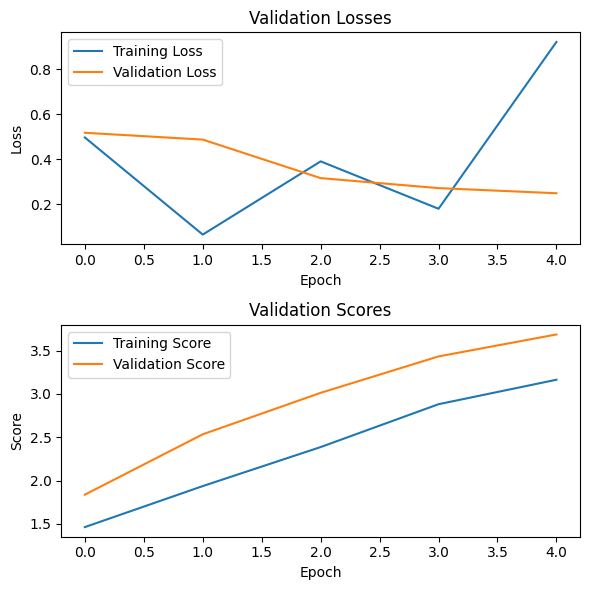

In [25]:
plt.figure(figsize=(6, 6))

plt.subplot(2, 1, 1)
x = np.arange(len(trainlosses))
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, trainlosses, label='Training Loss')
plt.plot(x, vallosses, label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
x = np.arange(len(trainscores))
plt.title('Validation Scores')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.plot(x, trainscores, label='Training Score')
plt.plot(x, validscores, label='Validation Score')
plt.legend()

plt.tight_layout()
plt.show()

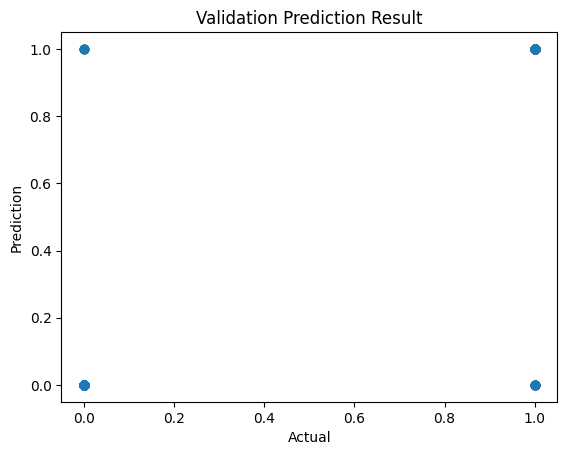


              precision    recall  f1-score   support

         ham     0.9068    0.9511    0.9284       593
        spam     0.8592    0.7532    0.8027       235

    accuracy                         0.8949       828
   macro avg     0.8830    0.8521    0.8656       828
weighted avg     0.8933    0.8949    0.8927       828



In [26]:
val_true = valid['targets']

val_pred = [ 0 if (p<0) else 1 for p in preds]

plt.scatter(val_true,val_pred, alpha=0.2)
plt.title('Validation Prediction Result')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

print("")
print(classification_report(val_true,val_pred,target_names=class_names,digits=4))

Comme on peut le voir les résultats sont plutôt bons. La précision globale (accuracy) du modèle est d'environ de 85%.

Cependant on remarque bien que les performances sont bien meilleures pour la classe Ham que pour celle des spam. Le manque d'échantillions dû à la répartiton des lables dans le training set peut en être la cause.

Par ailleurs les faux postifs et négatifs sont primordiaux dans notre cas. En effet on souhaite évitez que les mails légitimes soient classifiés comme spam. Ici on trouve qu'environ 20% des spams ne le sont enfaite pas, ce qui n'est idéal.

# Cross validation

## Generating the folds

Au vu des précédents résultats nous allons essayer d'améliorer les performances de notre modèle. Une des pistes d'améliorations est d'augmenter le volume de données d'entraînement. Ceependant il existe peu de dataset qui traite de la classification de spam, peut être car les gens ne sont pas enclins à partager leurs infos personnelles.

Nous avons donc décidé de procéder à une cross valdiation. Cette technique permet de générer plusieurs entraînement différents à partir des mêmes données en les découpant en plis et en les mélangeant pour créer un nouveau dataset.

In [27]:
fold_number = 5

train, test = train_test_split(data, test_size=0.2, random_state=SEED)

shuffled_data = train.sample(frac=1, random_state=SEED).reset_index(drop=True)
shuffled_data["kfold"] = shuffled_data.index % fold_number

# Separate into train, validation, and test sets
p_train = shuffled_data[shuffled_data["kfold"] != 0].reset_index(drop=True)
p_valid = shuffled_data[shuffled_data["kfold"] == 0].reset_index(drop=True)
p_test = test.reset_index(drop=True)

print("Training set:")
print(p_train)
print("\nValidation set:")
print(p_valid)

Training set:
     label                                               text  targets  kfold
0      ham  Subject: industrial accounts\r\ni will leave r...        0      1
1      ham  Subject: april - - - flexible katy gas\r\nfyi ...        0      2
2      ham  Subject: re : aquila header - 12 / 12 / 00 flo...        0      3
3     spam  Subject: adobe 75 % off ! !\r\ntable align = c...        1      4
4      ham  Subject: koch midstream services co\r\ni have ...        0      1
...    ...                                                ...      ...    ...
3303  spam  Subject: = ? iso - 8859 - 7 ? q ? = 5 b = 3 f ...        1      4
3304   ham  Subject: hpl nom for october 27 , 2000\r\n( se...        0      1
3305  spam  Subject: lose while you sleep ! as seen on opr...        1      2
3306   ham  Subject: cornhusker for sept\r\ni was informed...        0      3
3307   ham  Subject: may hours survey\r\nif you guys remeb...        0      4

[3308 rows x 4 columns]

Validation set:
    labe

## Visualizing the folds

La répartiton des labels étant complétement aléatoire il nous a semblé judicieux de visualier les différents folds. Certaines répartitons atypiqyes (style 95% ham - 5% spam) pourrait expliquer certaiens exemples étonants.

Label repartition in fold 1
ham     1784
spam     697
Name: label, dtype: int64

Label repartition in fold 2
ham     1755
spam     726
Name: label, dtype: int64

Label repartition in fold 3
ham     1766
spam     715
Name: label, dtype: int64

Label repartition in fold 4
ham     1763
spam     718
Name: label, dtype: int64



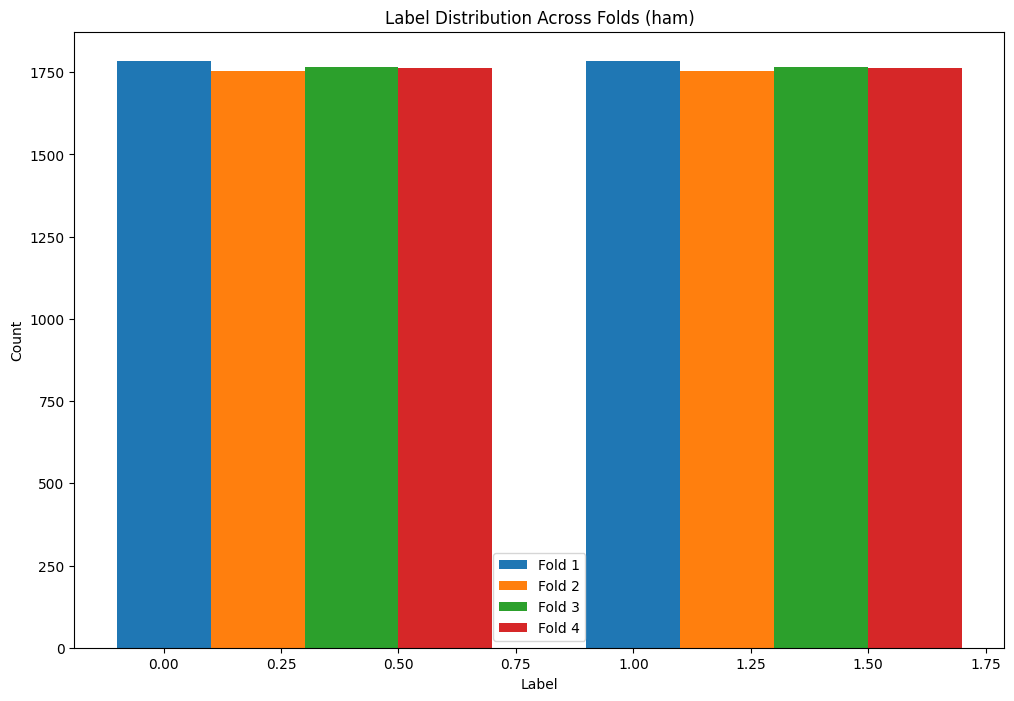

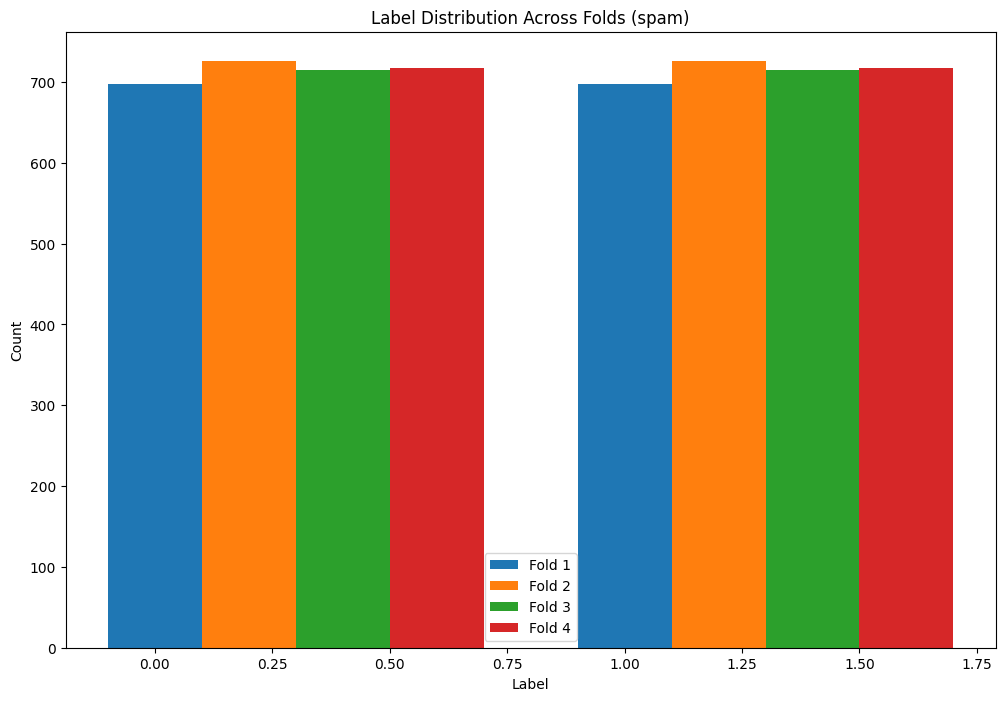

In [28]:
for fold in range(1, fold_number):
    print("Label repartition in fold", fold)
    label_count = p_train[p_train['kfold'] != fold]['label'].value_counts().sort_index()
    print(label_count)
    print("")

fig_ham, ax_ham = plt.subplots(figsize=(12, 8))
fig_spam, ax_spam = plt.subplots(figsize=(12, 8))

for fold in range(1, fold_number):
    p_train_fold = p_train[p_train["kfold"] != fold].reset_index(drop=True)
    label_count = p_train_fold['label'].value_counts().sort_index()

    # Plot the distribution for each fold on the ham or spam plot
    positions = range(len(label_count))
    if 'ham' in label_count.index:
        ax_ham.bar([pos + (fold - 1) * 0.2 for pos in positions], label_count['ham'], width=0.2, label=f'Fold {fold}')
    if 'spam' in label_count.index:
        ax_spam.bar([pos + (fold - 1) * 0.2 for pos in positions], label_count['spam'], width=0.2, label=f'Fold {fold}')

# Set titles and labels for ham plot
ax_ham.set_title('Label Distribution Across Folds (ham)')
ax_ham.set_xlabel('Label')
ax_ham.set_ylabel('Count')
ax_ham.legend()

# Set titles and labels for spam plot
ax_spam.set_title('Label Distribution Across Folds (spam)')
ax_spam.set_xlabel('Label')
ax_spam.set_ylabel('Count')
ax_spam.legend()

plt.show()

## Computing

In [29]:
foldscores = []
foldtrainlosses = []
foldvallosses = []
foldtrainscores = []
foldvalidscores = []

for fold in range(0,fold_number):

    print("~~~~~~~~~~~~~~~~ start fold " + str(fold) + " ~~~~~~~~~~~~~~~~")

    # Initializing the data
    p_train_fold = shuffled_data[shuffled_data["kfold"]!=fold].reset_index(drop=True)
    p_valid_fold = shuffled_data[shuffled_data["kfold"]==fold].reset_index(drop=True)

    train_dataset = BERTDataSet(p_train_fold["text"],p_train_fold['targets'])
    valid_dataset = BERTDataSet(p_valid_fold["text"],p_valid_fold['targets'])

    train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=4,pin_memory=True)
    valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=4,pin_memory=True)

    # # Initializing the model
    #model = transformers.XLMRobertaForSequenceClassification.from_pretrained("alexandrainst/da-ned-base", num_labels=2, ignore_mismatched_sizes=True)
    #model.to(device)

    #LR=2e-5
    #optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2) # AdamW optimizer

    # # Initializing the scheduler
    train_steps = int(len(p_train_fold)/train_batch*epochs)
    num_steps = int(train_steps*0.1)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

    trainlosses = []
    vallosses = []
    foldscore = None
    trainscores = []
    validscores = []

    for epoch in tqdm(range(epochs)):

      print("--------------- start epoch " + str(epoch) + " ---------------")

      trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler,scaler, loss_fn)
      trainlosses.append(trainloss)
      trainscores.append(trainscore)

      print("trainscore is " + str(trainscore))

      preds,validloss,valscore=validating(valid_dataloader,model)
      vallosses.append(validloss)
      validscores.append(valscore)

      print("valscore is " + str(valscore))
      time.sleep(1) #Fix the print

      if foldscore is None or foldscore < valscore:
        foldscore = valscore

        # Sauvegarde uniquement si la performance de validation est améliorée
        state = {
            'state_dict': model.state_dict(),
            'optimizer_dict': optimizer.state_dict(),
            "bestscore": foldscore
        }
        torch.save(state, "model_fold_" + str(fold) + ".pth")

    foldscores.append(foldscore)
    foldtrainlosses.append(trainlosses)
    foldvallosses.append(vallosses)
    foldtrainscores.append(trainscores)
    foldvalidscores.append(validscores)



~~~~~~~~~~~~~~~~ start fold 0 ~~~~~~~~~~~~~~~~


  0%|          | 0/5 [00:00<?, ?it/s]

--------------- start epoch 0 ---------------
trainscore is 3.0064812
valscore is 3.340952


 20%|██        | 1/5 [01:31<06:07, 91.91s/it]

--------------- start epoch 1 ---------------
trainscore is 3.3551888
valscore is 4.3663607


 40%|████      | 2/5 [02:48<04:08, 82.91s/it]

--------------- start epoch 2 ---------------
trainscore is 4.192003
valscore is 4.6813025


 60%|██████    | 3/5 [04:09<02:44, 82.19s/it]

--------------- start epoch 3 ---------------
trainscore is 4.576636
valscore is 5.194027


 80%|████████  | 4/5 [05:42<01:26, 86.13s/it]

--------------- start epoch 4 ---------------
trainscore is 5.0039454
valscore is 5.484236


100%|██████████| 5/5 [07:04<00:00, 84.84s/it]


~~~~~~~~~~~~~~~~ start fold 1 ~~~~~~~~~~~~~~~~


  0%|          | 0/5 [00:00<?, ?it/s]

--------------- start epoch 0 ---------------
trainscore is 4.580475
valscore is 3.234977


 20%|██        | 1/5 [01:24<05:38, 84.60s/it]

--------------- start epoch 1 ---------------
trainscore is 4.1952214
valscore is 4.8269024


 40%|████      | 2/5 [02:43<04:03, 81.12s/it]

--------------- start epoch 2 ---------------
trainscore is 4.7363167
valscore is 5.4005184


 60%|██████    | 3/5 [04:12<02:49, 84.60s/it]

--------------- start epoch 3 ---------------
trainscore is 5.381279
valscore is 6.0257983


 80%|████████  | 4/5 [05:29<01:21, 81.69s/it]

--------------- start epoch 4 ---------------
trainscore is 5.8520174
valscore is 6.2513986


100%|██████████| 5/5 [06:46<00:00, 81.38s/it]


~~~~~~~~~~~~~~~~ start fold 2 ~~~~~~~~~~~~~~~~


  0%|          | 0/5 [00:00<?, ?it/s]

--------------- start epoch 0 ---------------
trainscore is 5.390482
valscore is 6.0025654


 20%|██        | 1/5 [01:26<05:44, 86.18s/it]

--------------- start epoch 1 ---------------
trainscore is 5.2944074
valscore is 6.369721


 40%|████      | 2/5 [02:48<04:11, 83.92s/it]

--------------- start epoch 2 ---------------
trainscore is 5.8486776
valscore is 6.6689887


 60%|██████    | 3/5 [04:22<02:56, 88.45s/it]

--------------- start epoch 3 ---------------
trainscore is 6.383096
valscore is 6.9950237


 80%|████████  | 4/5 [05:49<01:28, 88.06s/it]

--------------- start epoch 4 ---------------
trainscore is 6.607295
valscore is 7.100476


100%|██████████| 5/5 [07:06<00:00, 85.32s/it]


~~~~~~~~~~~~~~~~ start fold 3 ~~~~~~~~~~~~~~~~


  0%|          | 0/5 [00:00<?, ?it/s]

--------------- start epoch 0 ---------------
trainscore is 6.2065444
valscore is 6.6013446


 20%|██        | 1/5 [01:21<05:27, 81.75s/it]

--------------- start epoch 1 ---------------
trainscore is 5.8279486
valscore is 5.8700676


 40%|████      | 2/5 [02:20<03:24, 68.05s/it]

--------------- start epoch 2 ---------------
trainscore is 5.8073606
valscore is 5.8846664


 60%|██████    | 3/5 [03:19<02:08, 64.01s/it]

--------------- start epoch 3 ---------------
trainscore is 5.949602
valscore is 6.692912


 80%|████████  | 4/5 [04:46<01:13, 73.17s/it]

--------------- start epoch 4 ---------------
trainscore is 6.3719025
valscore is 7.0279527


100%|██████████| 5/5 [06:13<00:00, 74.68s/it]


~~~~~~~~~~~~~~~~ start fold 4 ~~~~~~~~~~~~~~~~


  0%|          | 0/5 [00:00<?, ?it/s]

--------------- start epoch 0 ---------------
trainscore is 6.0921087
valscore is 5.751215


 20%|██        | 1/5 [01:27<05:49, 87.34s/it]

--------------- start epoch 1 ---------------
trainscore is 5.757853
valscore is 6.8819356


 40%|████      | 2/5 [02:49<04:12, 84.15s/it]

--------------- start epoch 2 ---------------
trainscore is 6.6088495
valscore is 7.3282337


 60%|██████    | 3/5 [04:06<02:42, 81.09s/it]

--------------- start epoch 3 ---------------
trainscore is 6.6583033
valscore is 7.323559


 80%|████████  | 4/5 [05:05<01:12, 72.34s/it]

--------------- start epoch 4 ---------------
trainscore is 6.900965
valscore is 7.451046


100%|██████████| 5/5 [06:23<00:00, 76.65s/it]


## Results

In [30]:
print("train losses: ", foldtrainlosses)
print("val losses: ", foldvallosses)
print("train scores: ", foldtrainscores)
print("valid scores: ", foldvalidscores)
print("best scores: ", foldscores)
print("best scores average: ", np.mean(foldscores))

train losses:  [[0.3520353436470032, 0.010540788993239403, 0.02856352925300598, 0.002938279416412115, 0.005699280649423599], [0.08549654483795166, 0.10226000845432281, 0.07959591597318649, 0.10939683765172958, 0.11538954079151154], [0.08630937337875366, 0.01736002042889595, 0.0033476834651082754, 0.008365697227418423, 0.006230134516954422], [0.189738467335701, 0.026363521814346313, 0.013511652126908302, 0.0012904604664072394, 0.013254641555249691], [0.004608231130987406, 0.000548830081243068, 0.0006911071250215173, 0.0006349504110403359, 0.0010859471512958407]]
val losses:  [[0.08428503572940826, 0.059690188616514206, 0.11282084882259369, 0.08780362457036972, 0.16986195743083954], [0.06940016895532608, 0.03342263773083687, 0.00890378374606371, 0.002425855491310358, 0.0015717222122475505], [0.8011557459831238, 0.04347362741827965, 0.03163648396730423, 0.007802323903888464, 0.004041788633912802], [0.004490993916988373, 0.021320655941963196, 0.0016486523672938347, 0.0016379202716052532, 0

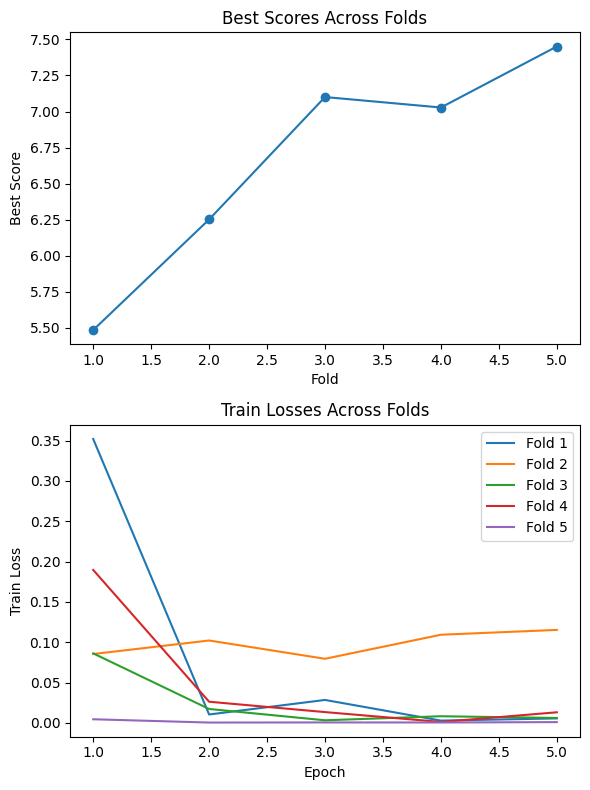

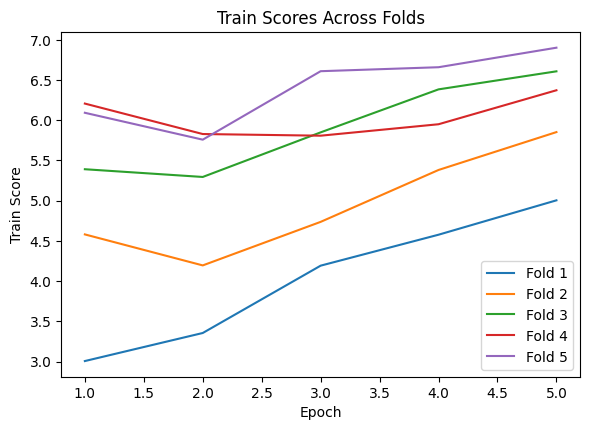

In [31]:
plt.figure(figsize=(6, 8))

# Plot best scores for each fold
plt.subplot(2, 1, 1)
plt.title('Best Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('Best Score')
plt.plot(range(1, len(foldscores) + 1), foldscores, marker='o')

plt.subplot(2, 1, 2)
plt.title('Train Losses Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
for fold, losses in enumerate(foldtrainlosses):
    plt.plot(range(1, epochs + 1), losses, label=f'Fold {fold + 1}')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 2)
plt.title('Train Scores Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Train Score')
for fold, scores in enumerate(foldtrainscores):
    plt.plot(range(1, epochs + 1), scores, label=f'Fold {fold + 1}')
plt.legend()

plt.tight_layout()
plt.show()

Comme on peut le voir sur les différents diagrammes l'utilisation d'une cross validation permet bien d'obtenir des résultats différents à partir du même dataset. Notament en comparant la courbe des meilleurs scores de validation (bestcore) on se rend compte de l'intérêt de cette technique.

## Updating the best model

On en profite pour sauvegarder le meilleur modèle pour le ré-employer dans la piepeline.

In [32]:
if bestscore < max(foldscores):

    new_best_index = foldscores.index(max(foldscores))

    # Get the corresponding model file path
    new_best_model_path = os.path.join("", f"model_fold_{new_best_index}.pth")

    # Overwrite the best_model.pth file with the new best model
    best_model_path = os.path.join("", "best_model.pth")
    shutil.copy(new_best_model_path, best_model_path)

    print(f"Best model updated. New best score: {max(foldscores)} from model_fold_{new_best_index}.pth")
else:
    print("No better score found. Best model remains unchanged.")


Best model updated. New best score: 7.451045989990234 from model_fold_4.pth


# Prediction

## Without using saved models

In [ ]:
def predicting(test_dataloader,model):

    model.to(device)
    model.eval()
    allpreds = []
    preds = []
    allvalloss=0

    with torch.no_grad():
        for a in test_dataloader:

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            preds.append(output.cpu().numpy())

        preds = np.concatenate(preds)
        allpreds.append(preds)

    return allpreds

## Using saved models

In [ ]:
#model initialized
#model = transformers.RobertaForSequenceClassification.from_pretrained("roberta-base",num_labels=1)
model = transformers.XLMRobertaForSequenceClassification.from_pretrained("alexandrainst/da-ned-base", num_labels=1, ignore_mismatched_sizes=True)

def predicting_with_model(test_dataloader,model,pthes):

  state = torch.load(pth)
  model.load_state_dict(state["state_dict"])
  model.to(device)
  model.eval()
  preds = []
  allvalloss=0

  with torch.no_grad():

    for a in test_dataloader:

      ids = a["ids"].to(device)
      mask = a["mask"].to(device)

      output = model(ids,mask)
      output = output["logits"].squeeze(-1)
      preds = np.append(preds,output.cpu().numpy())

  return preds

## Predicting

In [ ]:
#tpreds = predicting(test_dataloader,model)

pths = [os.path.join("./",s) for s in os.listdir("./") if "model.pth" in s]

tpreds = []
for pth in pths:
  tpreds.append(predicting_with_model(test_dataloader,model,pth))

In [36]:
test_true = test['targets']


test_pred = []
for preds in tpreds:
  test_pred = []
  for p in preds:
    test_pred+=[ 0 if(p<0) else 1]

  print( "result for best_model.pth \n")
  print(classification_report(test_true,test_pred,target_names=['ham','spam'],digits=4))

result for best_model.pth 

              precision    recall  f1-score   support

         ham     0.9270    0.9628    0.9445       725
        spam     0.9043    0.8226    0.8615       310

    accuracy                         0.9208      1035
   macro avg     0.9156    0.8927    0.9030      1035
weighted avg     0.9202    0.9208    0.9196      1035



On se rend bien compte de l'amélioration des performances suite à l'utilisation de la cross validation. En effet on a pu augmenter la précision global à environ 91% et diminuer le nombre de faux positif à 10% ce qui est deux fois mieux que précédement.

# Pipeline

Pour finir nous avons créé une pipeline. Cette pipeline prend en entrée le texte d'un mail et son label et produit en résultat l'évaluation du modèle. Le but derrière cette pipeline est de vérifier les limites de notre modéle.

On peut penser à des mails déguisés en spam comme un prank ou des spam très bien forgés, des mails bancaires que l'on considère tous aujourd'hui comme des spam d'office, des mails bourrés de fautes d'ortographe, des mails ontenant beaucoup de code HTML, etc ...

In [ ]:
best_model_path = "best_model.pth"  # Update with your actual path
model = transformers.XLMRobertaForSequenceClassification.from_pretrained("alexandrainst/da-ned-base", num_labels=1, ignore_mismatched_sizes=True)
model = model.to(device)
state = torch.load(pth)
model.load_state_dict(state["state_dict"])


In [38]:
example_spam = '''Subject: underpriced issue with high return on equity
stock report .
dont sieep on this stock ! this is a hot one !
company : gaming transactions inc .
stock symbol : ggts
currentiy trading at : o . 30
rating : strong purchase
near - term target : 0 . 45
long - term target : 1 . oo
breaking news for ggts :
gaming transactions inc . ( ggts ) , a | eading provider of online gaming
porta | management is pleased to announce that it has launched its
proprietary gaming portal ( k e n o . com ) furthermore , the company has begun an
intensive marketing campaign to support the | aunch and establish itself
as the | eader in the online gaming industry .
( k e n o . c o m ) is an oniine games destination where people piay
popular casino style games to win real money . the foundation of the site is
an online version of keno . the game of keno uses 80 balls numbered 1
thru 8 o . every game , the house draws 20 bails at random and displays
their numbers on screens ( called keno boards ) located on the website . the
object of the game is for the player to guess some of the numbers the
house will draw . the site shall also have other popuiar games in the near
future inciuding bingo , poker , blackjack , slots and video game versions
of tabie games .
patrick smyth , ceo of gaming transactions inc . , remarked that , the
games have been deveioped with the foresight to create a user - friendly
experience without loading times and a secure transaction system has been
deveioped with multipie layers of security and redundancy . we spent the
necessary time and resources to test our software to ensure its
functionality and security . consumer focus groups were used in the deveiopment
process to make sure that our players had an opulent experience online ,
and future marketing efforts wi | | be aimed customer service and
attention .
about the company :
gaming transactions inc . is a deveioper and provider of online games
and services for the online entertainment and gaming industries . the
company ! s centra | licensed games portal , ( k e n o . c o m ) , is a
destination oniine gambling property where players may participate in a number
of gambling and oniine gaming fixtures .
the foundation of the site is of course an online version of keno . the
game of keno uses 8 o bails numbered 1 thru 80 . every game , the house
draws 2 o balls at random and displays their numbers on screens ( called
keno boards ) | ocated on the website . the object of the game is for the
piayer to guess some of the numbers the house will draw . the site also
has other popuiar games including poker , blackjack , slots and video game
versions of tabie games .
gaming transactions inc . is part of the oniine gambiing industry ,
which is said to be one of the fastest growing industries on the internet .
! ' the electronic gambling report forecasts that revenues will reach
14 . 5 biliion by 2006 ! ( market statistics : - informa media grp . giobal
revenues from oniine gambiing wi | | reach 14 . 52 bi | | ion in 20 o 6 , up from
3 . 81 biilion this year . this is according to a report from the informa
media grp . , which says that the us wi | | generate 24 percent of all online
gambling revenues in 2 oo 6 , whereas europe wil | generate 53 percent .
north american oniine gambling revenues are expected to reach 1 . 99 biliion
this year and 3 . 85 bi | | ion in 2 oo 6 . in europe , revenues wil | grow from
1 . 29 billion this year to 7 . 64 biilion in 2 oo 6 . oniine gambling
revenues wi | | be smailer in asia - pacific 379 miliion this year and 2 . 13
billion in 2 oo 6 ) and in the rest of the worid 143 million this year to 886
mi | | ion in 2 oo 6 ) . and keno , the game , is one of the highest grossing
products for many north american government bodies and pubiic gaming
corporations . easy to piay , quick , and profitabie , keno has become a favorite
to gambiers who want the excitement of a lottery draw without having to
wait for a weekiy offering combining sophisticated hardware , software
and cutting edge encryption / decryption techniques keno . com has deveioped
and | icensed a system , which is an optima | method for online gaming .
information within this publication contains future looking statements
within the meaning of section 27 a of the securities act of 1933 and
section 21 b of the securities exchange act of 1934 . any statements that
express or involve discussions with respect to predictions ,
expectations , beliefs , pians , projections , objectives , goals , assumptions or future
events or performance are not statements of historica | fact and may be
future looking statements . future | ooking statements are based on
expectations , estimates and projections at the time the statements are made
that involve a number of risks and uncertainties which couid cause
actual results or events to differ materia | | y from those presently
anticipated . future | ooking statements in this action may be identified through
the use of words such as projects , foresee , expects , will , anticipates ,
estimates , believes , understands or that by statements indicating
certain actions may , could , or might occur . these future - | ooking statements
are based on information currentiy avaiiabie and are subject to a
number of risks , uncertainties and other factors that couid cause ggts ' s
actua | resuits , performance , prospects or opportunities to differ
materialiy from those expressed in , or impiied by , these future - | ooking
statements . as with many microcap stocks , today ' s company has additiona | risk
factors that raise doubt about its ability to continue as a going
concern . ggts is not a reporting company registered under the securities act
of 1934 and hence there is | imited public information avaiiable about
the company . these risks , uncertainties and other factors include ,
without | imitation , the company ' s growth expectations and ongoing funding
requirements , and specificaily , the company ' s growth prospects with
scalable customers . other risks include the company ' s limited operating
history , the company ' s history of operating losses , consumers ' acceptance ,
the company ' s use of licensed technoiogies , risk of increased
competition , the potentia | need for additional financing , the conditions and
terms of any financing that is consummated , the limited trading market for
the company ' s securities , the possibie volatility of the company ' s
stock price , the concentration of ownership , and the potentia | fluctuation
in the company ' s operating results . the publisher of this report does
not represent that the information contained in this message states ail
material facts or does not omit a material fact necessary to make the
statements therein not misieading . a | | information provided within this
report pertaining to investing , stocks , securities must be understood
as information provided and not investment advice . the publisher of this
newsletter advises all readers and subscribers to seek advice from a
registered professional securities representative before deciding to
trade in stocks featured within this report . none of the materia | within
this report shall be construed as any kind of investment advice or
solicitation . many of these companies are on the verge of bankruptcy . you can
lose al | your money by investing in this stock . the pubiisher of this
report is not a registered investment expert . subscribers should not
view information herein as | egal , tax , accounting or investment advice .
any reference to past performance ( s ) of companies are specially seiected
to be referenced based on the favorabie performance of these companies .
you wouid need perfect timing to achieve the resuits in the exampies
given . there can be no assurance of that happening . remember , as always ,
past performance is not indicative of future results and a thorough due
diligence effort , inciuding a review of a company ' s fiiings at sec gov
or edgar - online com when avaiiabie , shouid be compieted prior to
investing . al | factua | information in this report was gathered from pubiic
sources , including but not | imited to company websites and company press
releases . the pubiisher discloses the receipt of fifteen thousand
doilars from a third party , not an officer , director , or affiiiate
shareholder of the company for the preparation of this oniine report . be aware
of an inherent confiict of interest resulting from such compensation
due to the fact that this is a paid pubiication . the pubiisher of this
report beiieves this information to be reiiable but can make no assurance
as to its accuracy or compieteness . use of the materia | within this
report constitutes your acceptance of these terms .
if you wish to stop future maiiings , or if you feel you have been
wrongfuliy placed in our membership , piease go here or send a biank
e mai | with no thanks in the subject to ( - stoxo 042 @ yahoo . com - ).'''


example_ham = '''Subject: re : first delivery - wheeler operating
vance ,
deal # 643714 has been created and entered in sitara .
bob
vance l taylor
02 / 23 / 2001 04 : 55 pm
to : robert cotten / hou / ect @ ect
cc : julie meyers / hou / ect @ ect , lisa hesse / hou / ect @ ect , cynthia
hakemack / hou / ect @ ect , susan smith / hou / ect @ ect , donald p
reinhardt / hou / ect @ ect , melissa graves / hou / ect @ ect
subject : first delivery - wheeler operating
bob ,
the following production is now on - line and a ticket should be created and
entered into sitara based on the following :
counterparty meter volumes price period global no .
wheeler operating 9879 800 mmbtu / d 85 % gas daily 2 / 17 - 2 / 28 nya
fyi , i have created and submitted a committed reserves firm ticket for the
remaining term of the deal beginning with the month of march . additionally ,
this is a producer svcs . deal and should be tracked in the im wellhead
portfolio . . . attached to the gathering contract .
thanks ,
vlt
x 3 - 6353
- - - - - - - - - - - - - - - - - - - - - - forwarded by vance l taylor / hou / ect on 02 / 23 / 2001
04 : 21 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -
from : esther buckley 02 / 22 / 2001 10 : 39 am
to : molly l carriere / hou / ect @ ect , clem cernosek / hou / ect @ ect , donna
consemiu / hou / ect @ ect , robert cook / hou / ect @ ect , howard b camp / hou / ect @ ect ,
lisa hesse / hou / ect @ ect , nathan l hlavaty / hou / ect @ ect , wayne e
lightfoot / hou / ect , james mckay / hou / ect @ ect , mary m smith / hou / ect @ ect , steve
hpl schneider / hou / ect @ ect , melissa graves / hou / ect @ ect , michael
walters / hou / ect @ ect , jill t zivley / hou / ect @ ect , mary jo johnson / hou / ees @ ees ,
rita wynne / hou / ect @ ect , lauri a allen / hou / ect @ ect , cheryl
jones / gpgfin / enron @ enron , reid hansen / gco / enron @ enron , darron c
giron / hou / ect @ ect , o ' neal d winfree / hou / ect @ ect , susan smith / hou / ect @ ect ,
gary bryan / hou / ect @ ect , gary a hanks / hou / ect @ ect , donald p
reinhardt / hou / ect @ ect , vance l taylor / hou / ect @ ect , david
baumbach / hou / ect @ ect , robert cotten / hou / ect @ ect , brian m riley / hou / ect @ ect ,
jeff a austin / hou / ees @ ees , cynthia hakemack / hou / ect @ ect , dawn c
kenne / hou / ect @ ect , lisa csikos / hou / ect @ ect , j r fosdick / gco / enron @ enron ,
carlos j rodriguez / hou / ect @ ect , stephanie gomes / hou / ect @ ect , pat
clynes / corp / enron @ enron , tom acton / corp / enron @ enron , robert
walker / hou / ect @ ect , george weissman / hou / ect @ ect , joanne
harris / na / enron @ enron , christy sweeney / hou / ect @ ect , earl tisdale / hou / ect @ ect ,
daren j farmer / hou / ect @ ect
cc :
subject : first delivery - wheeler operating
please see attached letter '''


In [ ]:
tokenizer = transformers.XLMRobertaTokenizer.from_pretrained("alexandrainst/da-ned-base")
example_encoded = tokenizer.encode_plus(
    # Switch here the input
    example_spam,
    add_special_tokens=True,
    max_length=max_sens,
    pad_to_max_length=True,
    return_attention_mask=True,
    truncation=True
)
ids = torch.tensor(example_encoded['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
mask = torch.tensor(example_encoded['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)


In [40]:
model.eval()
with torch.no_grad():
    output = model(ids, mask)["logits"].squeeze(-1)
    prediction = 0 if output < 0 else 1
    class_name = 'ham' if prediction == 0 else 'spam'

print(f"Prediction: {class_name}")


Prediction: spam
Prediction: spam
